In [96]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sb
from matplotlib import rc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import time
from collections import defaultdict

from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.activations import relu, tanh
from keras.optimizers import Adam

#from sknn.mlp import Regressor

from shrink_functions import X_y, time_split, ss
from model_functions import model_clusters, plot_rmse, clust_grid

In [97]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-bright')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [98]:
df = pd.read_pickle('data/SRP/clean_data_public_no_crime_lag2_by_store.pkl')
df_agg = df.groupby(['address1', 'visit_date']).mean().sort_index().reset_index()

cust_table_clust = pd.read_pickle('data/SRP/cust_table_clusters_biased.pkl')
df_agg = df_agg.join(cust_table_clust, on='address1', how='left')

In [99]:
item_cols = ['item_category_8',
       'item_category_10', 'item_category_16', 'item_category_19',
       'item_category_26', 'item_category_31', 'item_category_38',
       'item_category_41', 'item_category_43', 'item_category_44',
       'item_category_46', 'item_category_58', 'item_category_62',
       'item_category_77', 'item_category_79', 'item_category_90']

for col in item_cols:
    del df_agg[col]
    
id_cols = ['customer_id_2139', 'customer_id_1635139', 'customer_id_1903139',
       'customer_id_2331150', 'customer_id_2741156', 'customer_id_2773156',
       'customer_id_2782156', 'customer_id_2956160', 'customer_id_2977160',
       'customer_id_3083182', 'customer_id_3088198', 'customer_id_3088201',
       'customer_id_3089336', 'customer_id_3093327', 'customer_id_3093329',
       'customer_id_3097348']

for col in id_cols:
    df_agg[col] = df_agg[col].astype(np.uint8)

In [122]:
reg_cols = pickle.load(open('data/SRP/reg_cols.pkl', 'rb'))
cust_table_agg = pd.read_pickle('data/SRP/cust_table_agg.pkl')

## Split into features and targets

In [101]:
# split into features and targets
non_feature_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out',
               'shrink_value_ex_del', 'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink',
               'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 'qty_f', 'qty_out', 'qty_ex_del',
               'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day']
# X y split for forcast model
X, y = X_y(df_agg, non_feature_cols, target_col='shrink_value_per_day')

# time split for forcast test
split_date = pd.to_datetime('12/15/2017')
X_train, X_test, y_train, y_test = time_split(df_agg, 'visit_date', split_date, non_feature_cols, 
                                              target_col='shrink_value_per_day')

## Standardize and Scale

In [102]:
# save off non-scaled version (for naive comparison)
X_train_ns = X_train
X_test_ns = X_test

X_train = ss(X_train, std=True, scale=True)
X_test = ss(X_test, std=True, scale=True)
X = ss(X, std=True, scale=True)

In [103]:
# create mask of all numberical columns to be used in clustering/modeling

# forcasting columns (what is known months ahead of time)
forc_cols = ['FD_ratio', 'LAPOP1_10', 'POP2010', 'customer_id_1635139',
             'customer_id_1903139', 'customer_id_2139', 'customer_id_2331150',
             'customer_id_2741156', 'customer_id_2773156', 'customer_id_2782156',
             'customer_id_2956160', 'customer_id_2977160', 'customer_id_3083182',
             'customer_id_3088198', 'customer_id_3088201', 'customer_id_3089336',
             'customer_id_3093327', 'customer_id_3093329', 'customer_id_3097348',
             'dens_sq_mile', 'unemp_rate', 'qty_POG_limit', 'unit_price', 
             'shrink_value_per_day_lag1_by_store', 'shrink_value_per_day_lag2_by_store' ]

# mask to be used in calculations
model_mask_cols = forc_cols

## Determine Model Params

In [23]:
model = MLPRegressor()
params = {'hidden_layer_sizes': [(300,), (100,), (50,50), (50,50,50)], 'learning_rate_init': [0.01, 0.001, 0.0001], 
          'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['sgd','adam'],  'max_iter': [400]}
# params = {'hidden_layer_sizes': [(10)], 'learning_rate_init': [0.01], 
#           'activation': ['relu'], 'solver': ['adam'],  'max_iter': [10]}
clust_grid(model, params, X_train, y_train, model_mask_cols)


cluster:  1


/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the op

{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.0001, 'max_iter': 100, 'solver': 'adam'}


cluster:  2


/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the op

KeyboardInterrupt: 

## Train Test Model

In [111]:
rf = RandomForestRegressor(n_estimators=100, max_features=10, n_jobs=-1)

mlp1 = MLPRegressor(alpha=0.001, solver='adam', activation='relu', hidden_layer_sizes=(50,50), learning_rate_init=0.0001, max_iter=1000)
mlp2 = MLPRegressor(alpha=0.001, solver='adam', activation='relu', hidden_layer_sizes=(50,50), learning_rate_init=0.0001, max_iter=1000)
mlp3 = MLPRegressor(alpha=0.001, solver='adam', activation='relu', hidden_layer_sizes=(50,50), learning_rate_init=0.0001, max_iter=1000)
mlp4 = MLPRegressor(alpha=0.001, solver='adam', activation='tanh', hidden_layer_sizes=(50,50), learning_rate_init=0.0001, max_iter=1000)
mlp_list = [mlp1, mlp2, mlp3, mlp4]

cluster_rmse, naive_rmse, test_cluster_models = model_clusters(mlp_list, X_train, X_test, X_test_ns, 'shrink_value_per_day_lag1_by_store', model_mask_cols, y_train, y_test)

cluster:  1
cluster:  2
cluster:  3
cluster:  4


Average decrease: -0.8%


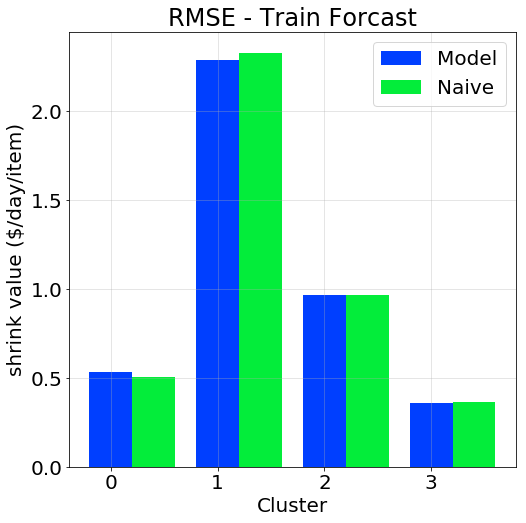

In [112]:
plot_rmse(cluster_rmse, naive_rmse, num_clusters=len(X_train.cluster.unique()), title='RMSE - Train Forcast')

## Test Model

In [113]:
def test_model(X_test, y_test, test_cluster_models, col_mask):
    rmse_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: [])))
    lag1_loc = X_test[col_mask].columns.get_loc('shrink_value_per_day_lag1_by_store')
    lag2_loc = X_test[col_mask].columns.get_loc('shrink_value_per_day_lag2_by_store')
    for add in X_test.address1.unique():
        add_mask = X_test.address1 == add
        foo = X_test[ add_mask ].sort_values('visit_date', ascending=True)
        clust = int(foo.cluster.values[0])
        # set initial lag variables to current value
        lag1_val = foo.shrink_value_per_day_lag1_by_store.values[0]
        lag2_val = foo.shrink_value_per_day_lag2_by_store.values[0]
        i = 0
        for index, row in foo.iterrows():
            model = cluster_models[clust]
            inputs = row[col_mask].values
            inputs[lag1_loc] = lag1_val
            inputs[lag2_loc] = lag2_val
            
            pred = model.predict(inputs.reshape(1, -1))                      
            actual = [y_test[index]]
            naive = [lag1_val]

            pred_rmse = np.sqrt(mean_squared_error(actual, pred))
            naive_rmse = np.sqrt(mean_squared_error(actual, naive))
            rmse_dict['{}'.format(i)]['pred'][clust].append(pred_rmse)
            rmse_dict['{}'.format(i)]['naive'][clust].append(naive_rmse)

            lag2_val = lag1_val
            lag1_val = pred
                                
            i += 1
    return rmse_dict

In [69]:
rmse_dict = test_model(X_test, y_test, test_cluster_models, model_mask_cols)

In [66]:
def split_dict(rmse_dict):
    num_clusts = len(rmse_dict['0']['pred'])
    for i in rmse_dict.keys():
        cluster_rmse = [0] * num_clusts
        naive_rmse = [0] * num_clusts
        for kind in rmse_dict[i].keys():
            for clust in rmse_dict[i][kind].keys():
                if kind == 'pred':
                    cluster_rmse[int(clust)] = np.mean(rmse_dict[i][kind][clust])
                else:
                    naive_rmse[int(clust)] = np.mean(rmse_dict[i][kind][clust])
        plot_rmse(cluster_rmse, naive_rmse, num_clusts, title='RMSE - {} Time Period(s) Forward'.format(int(i) + 1))

Average decrease: 43.8%


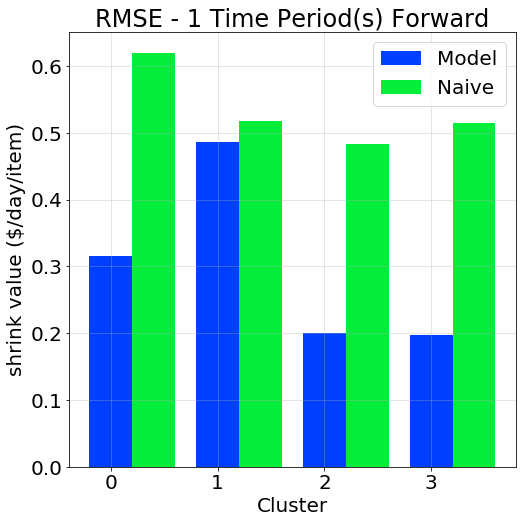

Average decrease: 3.1%


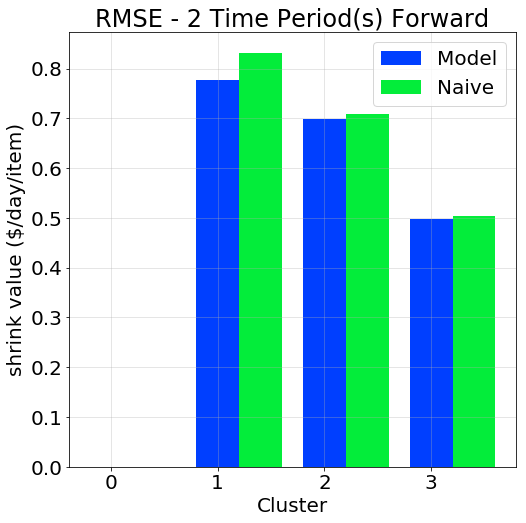

Average decrease: 16.2%


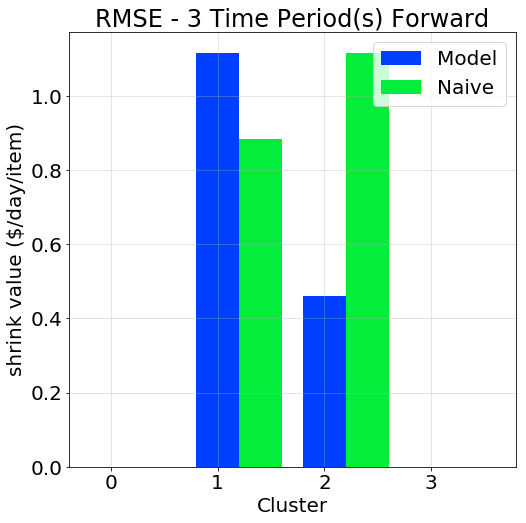

In [67]:
split_dict(rmse_dict)

## Forcast

In [115]:
def forc_models(X, y, model_list, col_mask):
    forc_cluster_models = []
    for index, model in enumerate(model_list):
        clust_mask = X.cluster == str(index)
        model.fit(X[col_mask][clust_mask], y[clust_mask])
        forc_cluster_models.append(model)
    return forc_cluster_models

In [116]:
forc_cluster_models = forc_models(X, y, mlp_list, model_mask_cols)

In [118]:
def forc_model(X, y, forc_cluster_models, col_mask, cust_table, num_periods):
    lag1_loc = X[col_mask].columns.get_loc('shrink_value_per_day_lag1_by_store')
    lag2_loc = X[col_mask].columns.get_loc('shrink_value_per_day_lag2_by_store')
    for add in X.address1.unique():
        add_mask = X.address1 == add
        foo = X[ add_mask ].sort_values('visit_date', ascending=False)
        top_index = foo.index[0]
        clust = int(foo.cluster.values[0])
        # get values from last visit for store
        base_input = foo[col_mask].values[0]
        base_actual = y[top_index]
        lag2_val = base_input[lag1_loc]
        lag1_val = base_actual

        for i in range(1, num_periods + 1):
            model = cluster_models[clust]
            inputs = base_input
            inputs[lag1_loc] = lag1_val
            inputs[lag2_loc] = lag2_val
            
            pred = model.predict(inputs.reshape(1, -1))
            cust_table.set_value(add, 'period{}_forc_shrink_value'.format(i), pred)
                
            lag2_val = lag1_val
            lag1_val = pred

In [ ]:
forc_model(X, y, forc_cluster_models, model_mask_cols, cust_table_agg, num_periods=4)

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [ ]:
cust_table_agg.head()

## Test other NNs

In [ ]:
def keras_MLP(X_train, X_test, y_train):
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1]))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
#     model.add(Dense(64, init='uniform'))
#     model.add(Activation('tanh'))
    adam = Adam()
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.fit(X_train, y_train, nb_epoch=20, batch_size=16)

In [ ]:
keras_MLP(X_train[model_mask_cols], X_test, y_train)

In [ ]:
X_train[model_mask_cols].shape

In [ ]:
reg = Regressor()